In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import datetime

In [8]:
Assets = ['USD_JPY', 'EUR_USD', 'GBP_USD', 'AUD_USD', 'XAU_USD', 'EUR_GBP', 'USD_CAD']

In [19]:
client = oandapyV20.API(access_token='541c1d09ea106d47855c4be050f4637d-26d78f76cd5e918ab269a4c23f23ce8d')
params = {
"count": 5000,
"granularity": "D"
}

In [20]:
data = []
for asset in Assets:
    r = instruments.InstrumentsCandles(instrument=asset, params=params)
    client.request(r)
    data.append(r.response['candles'])
    




In [21]:
dat = []
for oo in data[0]:
    dat.append([oo['time'], oo['volume'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])

df = pd.DataFrame(dat)
df.columns = ['Date', 'Volume', 'Open', 'High', 'Low', 'Close']
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(["Date"], drop=True)
df = df[["Close"]]
df = df.rename(columns={'Close': '%s'% Assets[0] })

for i in range(1,len(data)):    
    dat = []
    for oo in data[i]:
        dat.append([oo['time'], oo['volume'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])

    df1 = pd.DataFrame(dat)
    df1.columns = ['Date', 'Volume', 'Open', 'High', 'Low', 'Close']
    df1["Date"] = pd.to_datetime(df1["Date"])
    df1 = df1.set_index(["Date"], drop=True)
    df1 = df1[["Close"]]
    df1 = df1.rename(columns={'Close': '%s'% Assets[i]})
    df = pd.concat([df,df1],axis=1, join='inner')

In [22]:
df = df.astype(float)

In [23]:

df.head()

,USD_JPY,EUR_USD,GBP_USD,AUD_USD,XAU_USD,EUR_GBP,USD_CAD
Date,,,,,,,
2006-03-19 22:00:00+00:00,116.380,1.21644,1.7563,0.7204,555.00,0.69275,1.1610
2006-03-20 22:00:00+00:00,117.260,1.20952,1.7477,0.7166,552.20,0.69192,1.1644
2006-03-21 22:00:00+00:00,117.010,1.20774,1.7473,0.7186,550.90,0.69126,1.1663
2006-03-22 22:00:00+00:00,117.855,1.19710,1.7349,0.7149,549.85,0.68995,1.1646
2006-03-23 22:00:00+00:00,117.480,1.20340,1.7420,0.7087,560.45,0.69080,1.1675


In [24]:
returns = df.pct_change()[1:]

In [25]:
returns.head()

,USD_JPY,EUR_USD,GBP_USD,AUD_USD,XAU_USD,EUR_GBP,USD_CAD
Date,,,,,,,
2006-03-20 22:00:00+00:00,0.007561,-0.005689,-0.004897,-0.005275,-0.005045,-0.001198,0.002929
2006-03-21 22:00:00+00:00,-0.002132,-0.001472,-0.000229,0.002791,-0.002354,-0.000954,0.001632
2006-03-22 22:00:00+00:00,0.007222,-0.008810,-0.007097,-0.005149,-0.001906,-0.001895,-0.001458
2006-03-23 22:00:00+00:00,-0.003182,0.005263,0.004092,-0.008673,0.019278,0.001232,0.002490
2006-03-25 22:00:00+00:00,0.000724,0.000415,0.000517,0.000282,0.000000,-0.000217,0.000428


In [26]:
import statsmodels
from statsmodels.tsa.stattools import coint

In [29]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.10:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

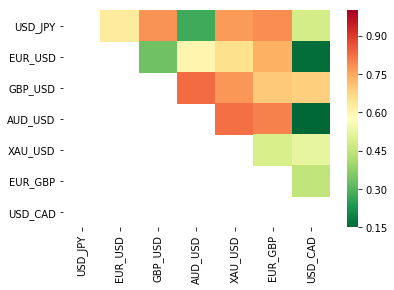

[]


In [30]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=Assets, 
                yticklabels=Assets, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)

0.16150961046626405


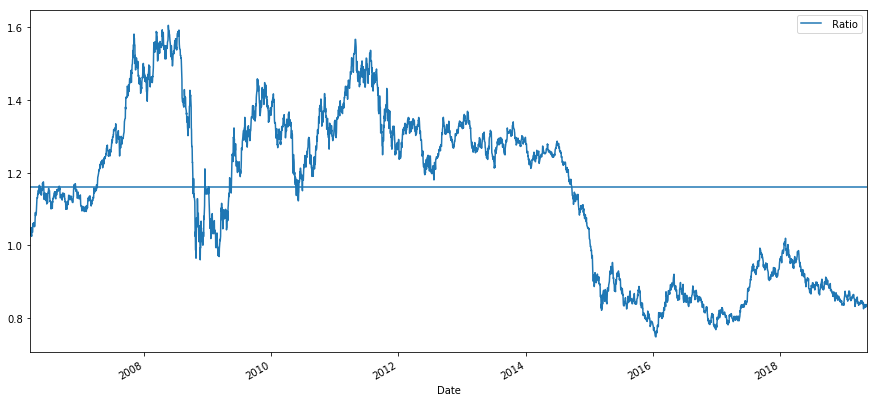

In [31]:
S1 = df['EUR_USD']
S2 = df['USD_CAD']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

In [32]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

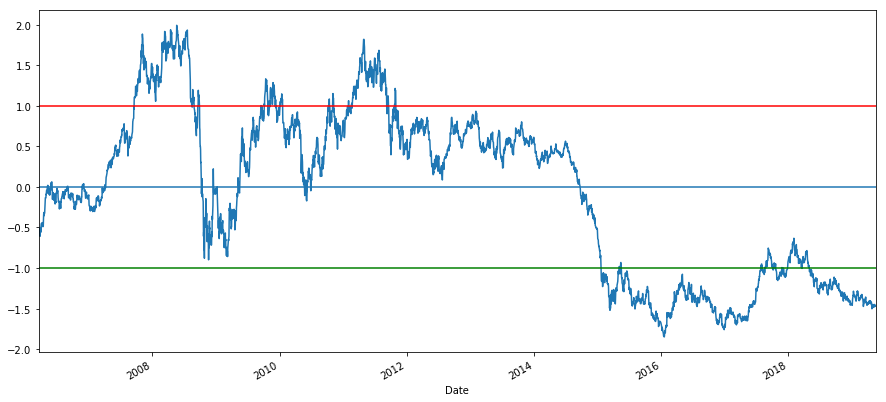

In [33]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [35]:

print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

3716


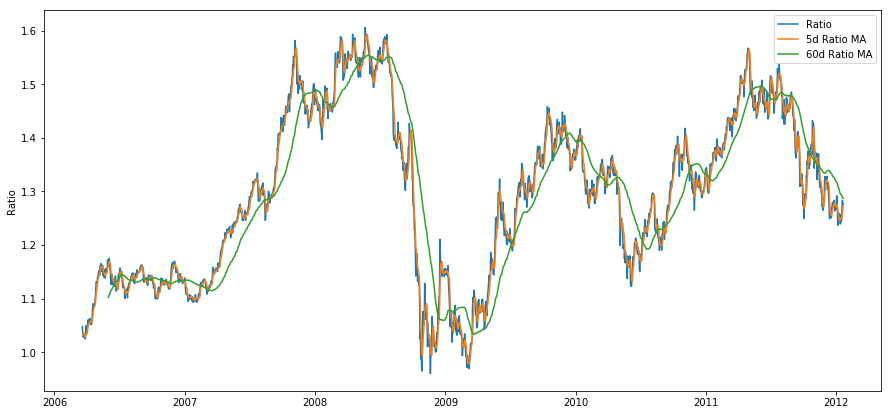

In [36]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()
std_60 = train.rolling(window=60,
                        center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

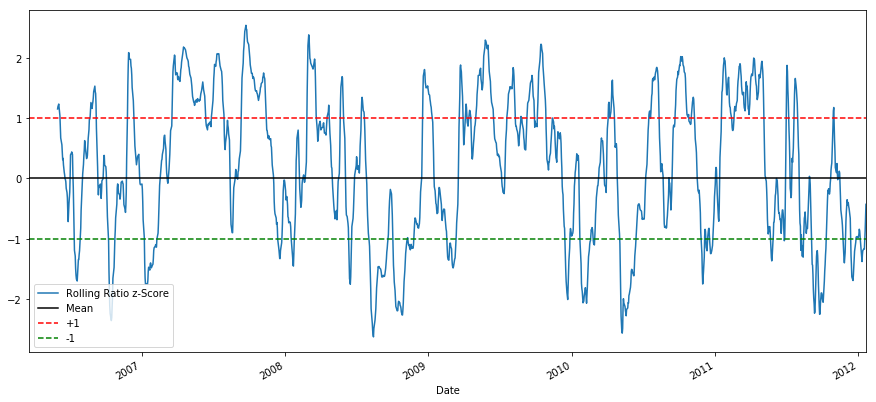

In [38]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

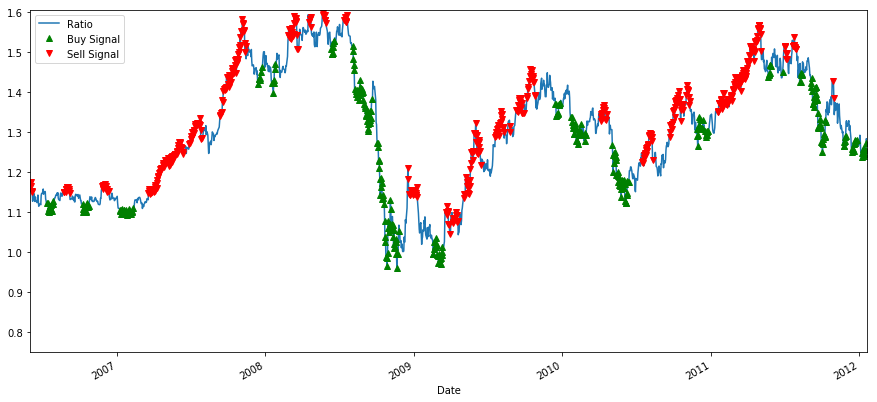

In [41]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='v')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

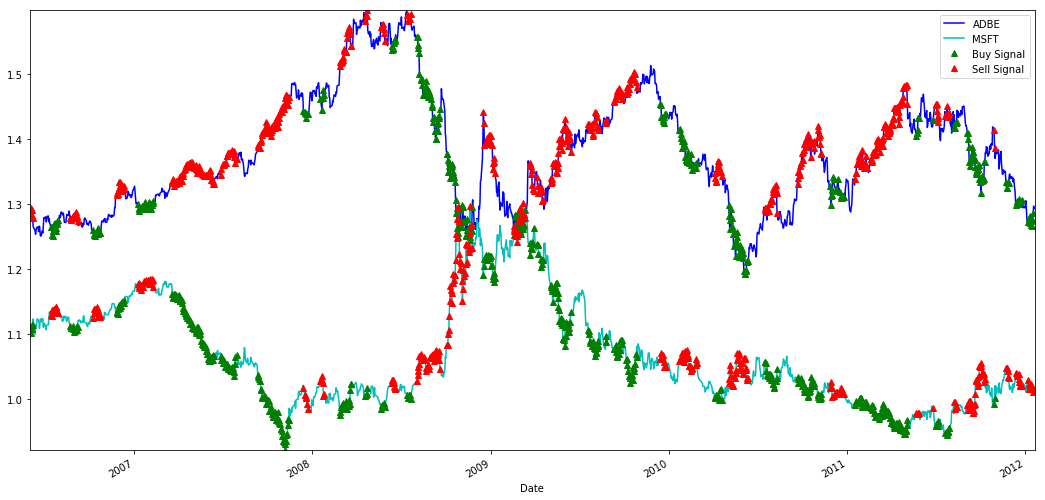

In [43]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = df['EUR_USD'].iloc[:1762]
S2 = df['USD_CAD'].iloc[:1762]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [50]:
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += countS1*S1[i] - S2[i] * countS2
            count = 0
            
    return money

In [51]:
trade(df['EUR_USD'].iloc[:1763], df['USD_CAD'].iloc[:1763], 60, 5)

97166.7622000158

In [52]:
trade(df['EUR_USD'].iloc[1763:], df['USD_CAD'].iloc[1763:], 60, 5)

-94462.78722089334

In [53]:
length_scores = [trade(df['EUR_USD'].iloc[:1763], df['USD_CAD'].iloc[:1763], l, 5) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 11


In [54]:
trade(df['EUR_USD'].iloc[:1763], df['USD_CAD'].iloc[:1763], 11, 5)

164821.3611672852

In [57]:
length_scores2 = [trade(df['EUR_USD'].iloc[1763:], df['USD_CAD'].iloc[1763:], l, 5) 
                for l in range(255)]
best_length2 = np.argmax(length_scores2)
print ('Best window length test:', best_length2)

Best window length test: 1


In [58]:
trade(df['EUR_USD'].iloc[1763:], df['USD_CAD'].iloc[1763:], 1, 5)

39378.73789275285